In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import os, shutil
import pickle

In [2]:
df_dict = []

In [3]:
def text_cleaning(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace(',','')
    return txt

In [4]:
folder = '../data/deduped_output/spam/'
for the_file in os.listdir(folder):
    fp = open(folder+ the_file)
    txt = fp.read()
    txt = text_cleaning(txt)
    df_dict.append({'txt':txt,'label':'spam'})

In [5]:
folder = '../data/deduped_output/posts/'
for the_file in os.listdir(folder):
    fp = open(folder+ the_file)
    txt = fp.read()
    txt = text_cleaning(txt)
    df_dict.append({'txt':txt,'label':'posts'})

In [6]:
train = pd.DataFrame(df_dict)

In [7]:
train = train.sample(frac=1).reset_index(drop=True)

In [8]:
train.head()

,txt,label
0,CUSTOMIZED DELIMITER,posts
1,Fcnantn 0-BT-10 CUSTOMIZED DELIMITER दुरा फ्रं...,posts
2,CUSTOMIZED DELIMITER,posts
3,CUSTOMIZED DELIMITER ट्टड्डित्सकी सुबह अच्छी ...,posts
4,CUSTOMIZED DELIMITER,posts


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 2 columns):
txt      1099 non-null object
label    1099 non-null object
dtypes: object(2)
memory usage: 17.3+ KB


In [10]:
train.isnull().sum()

txt      0
label    0
dtype: int64

In [11]:
train.label.value_counts()

posts    982
spam     117
Name: label, dtype: int64

### txt

In [12]:
train['txt'][2]

' CUSTOMIZED DELIMITER '

### Feature Engineering with txt

In [13]:
import string

In [14]:
train['ccs_char_count'] = train['txt'].apply(len)
train['ccs_word_count'] = train['txt'].apply(lambda x: len(x.split()))
train['ccs_word_density'] = train['ccs_char_count'] / (train['ccs_word_count']+1)
train['ccs_punctuation_count'] = train['txt'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train['ccs_title_word_count'] = train['txt'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train['ccs_upper_case_word_count'] = train['txt'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [15]:
train.head()

,txt,label,ccs_char_count,ccs_word_count,ccs_word_density,ccs_punctuation_count,ccs_title_word_count,ccs_upper_case_word_count
0,CUSTOMIZED DELIMITER,posts,22,2,7.333333,0,0,2
1,Fcnantn 0-BT-10 CUSTOMIZED DELIMITER दुरा फ्रं...,posts,55,9,5.500000,3,1,3
2,CUSTOMIZED DELIMITER,posts,22,2,7.333333,0,0,2
3,CUSTOMIZED DELIMITER ट्टड्डित्सकी सुबह अच्छी ...,posts,128,20,6.095238,1,0,2
4,CUSTOMIZED DELIMITER,posts,22,2,7.333333,0,0,2


In [16]:
train.head()

,txt,label,ccs_char_count,ccs_word_count,ccs_word_density,ccs_punctuation_count,ccs_title_word_count,ccs_upper_case_word_count
0,CUSTOMIZED DELIMITER,posts,22,2,7.333333,0,0,2
1,Fcnantn 0-BT-10 CUSTOMIZED DELIMITER दुरा फ्रं...,posts,55,9,5.500000,3,1,3
2,CUSTOMIZED DELIMITER,posts,22,2,7.333333,0,0,2
3,CUSTOMIZED DELIMITER ट्टड्डित्सकी सुबह अच्छी ...,posts,128,20,6.095238,1,0,2
4,CUSTOMIZED DELIMITER,posts,22,2,7.333333,0,0,2


### ccs_char_count

In [17]:
train['ccs_char_count'].describe()

count    1099.000000
mean      150.088262
std       322.531362
min        22.000000
25%        22.000000
50%        23.000000
75%       152.500000
max      4766.000000
Name: ccs_char_count, dtype: float64

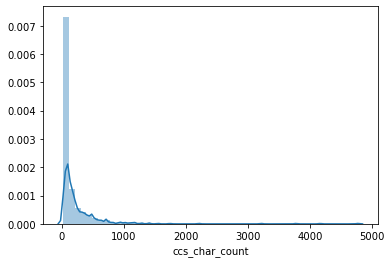

In [18]:
sns.distplot(train['ccs_char_count'])

### ccs_word_count

In [19]:
train['ccs_word_count'].describe()

count    1099.000000
mean       24.073703
std        58.533000
min         2.000000
25%         2.000000
50%         3.000000
75%        25.000000
max       940.000000
Name: ccs_word_count, dtype: float64

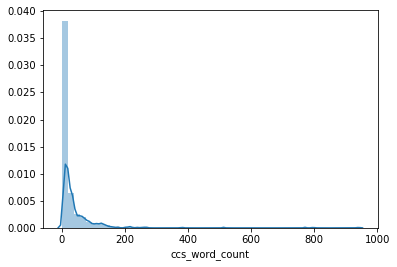

In [20]:
sns.distplot(train['ccs_word_count'])

### ccs_word_density

In [21]:
train['ccs_word_density'].describe()

count    1099.000000
mean        6.693169
std         0.992594
min         3.764706
25%         5.869500
50%         7.333333
75%         7.333333
max        11.468750
Name: ccs_word_density, dtype: float64

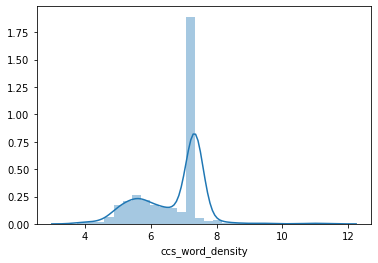

In [22]:
sns.distplot(train['ccs_word_density'])

### ccs_punctuation_count

In [23]:
train['ccs_punctuation_count'].describe()

count    1099.000000
mean        5.304823
std        24.272528
min         0.000000
25%         0.000000
50%         0.000000
75%         4.000000
max       676.000000
Name: ccs_punctuation_count, dtype: float64

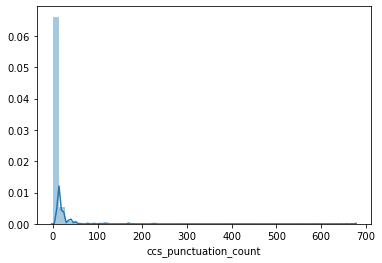

In [24]:
sns.distplot(train['ccs_punctuation_count'])

### ccs_title_word_count

In [25]:
train['ccs_title_word_count'].describe()

count    1099.000000
mean        2.188353
std         5.576265
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        73.000000
Name: ccs_title_word_count, dtype: float64

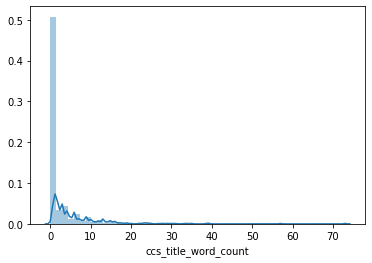

In [26]:
sns.distplot(train['ccs_title_word_count'])

### ccs_upper_case_word_count

In [27]:
train['ccs_upper_case_word_count'].describe()

count    1099.000000
mean        3.098271
std         2.828328
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        34.000000
Name: ccs_upper_case_word_count, dtype: float64

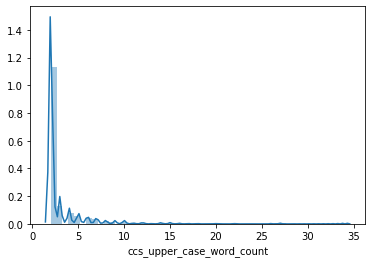

In [28]:
sns.distplot(train['ccs_upper_case_word_count'])

In [29]:
cont_cols = []

In [30]:
for col in train.columns:
    if train[col].dtype == 'int64' or train[col].dtype == 'float64':
        cont_cols.append(col)

In [31]:
cont_cols

['ccs_char_count',
 'ccs_word_count',
 'ccs_word_density',
 'ccs_punctuation_count',
 'ccs_title_word_count',
 'ccs_upper_case_word_count']

# Tf-Idf vectors as features

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [33]:
X_train,X_test,y_train,y_test = train_test_split(train.drop('label',axis=1),train['label'],test_size=0.33,stratify=train['label'],random_state=42)

In [34]:
len(X_train)

736

In [35]:
len(X_test)

363

In [36]:
from collections import Counter

In [37]:
Counter(y_train)

Counter({'posts': 658, 'spam': 78})

In [38]:
Counter(y_test)

Counter({'posts': 324, 'spam': 39})

In [39]:
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
with open('label_encode.pkl', 'wb') as fid:
    pickle.dump(encoder, fid) 

In [40]:
for col in cont_cols:
    scaler = preprocessing.RobustScaler()
    X_train[col] = scaler.fit_transform(np.array(X_train[col]).reshape(-1, 1))
#     valid_x[col] = scaler.transform(np.array(valid_x[col]).reshape(-1, 1))
    X_test[col] = scaler.transform(np.array(X_test[col]).reshape(-1, 1))
    with open(col + '.pkl', 'wb') as fid:
        pickle.dump(scaler, fid) 

In [41]:
X_train.head()

,txt,ccs_char_count,ccs_word_count,ccs_word_density,ccs_punctuation_count,ccs_title_word_count,ccs_upper_case_word_count
390,vite 9 ene fore wae free zak TRH wt) Htc aoa s...,6.207031,6.695652,-1.463547,2.25,4.0,6.0
53,Ral Cees era aed aei...’ RAC aqATG= GER CUSTOM...,1.292969,1.217391,-0.933305,5.25,1.0,2.0
564,CUSTOMIZED DELIMITER,-0.074219,-0.086957,0.000000,0.00,0.0,0.0
647,CUSTOMIZED DELIMITER,-0.074219,-0.086957,0.000000,0.00,0.0,0.0
332,CUSTOMIZED DELIMITER,-0.074219,-0.086957,0.000000,0.00,0.0,0.0


In [42]:
pd.DataFrame(y_train)[0].value_counts()

0    658
1     78
Name: 0, dtype: int64

In [43]:
train_text = X_train['txt']
test_text = X_test['txt']
all_text = pd.concat([train_text, test_text])

In [44]:
# word level tf-idf for Consumer-complaint-summary
tfidf_vect = TfidfVectorizer(analyzer='word',sublinear_tf=True,strip_accents='unicode',ngram_range=(1, 2),lowercase=True, stop_words='english', token_pattern=r'\w{1,}')
tfidf_vect.fit(all_text)
xtrain_tfidf =  tfidf_vect.transform(X_train['txt'])
# xvalid_tfidf =  tfidf_vect.transform(valid_x['Consumer-complaint-summary'])
xtest_tfidf =  tfidf_vect.transform(X_test['txt'])
with open('tfidf.pkl', 'wb') as fid:
    pickle.dump(tfidf_vect, fid) 
# char vectorizer
# char_vectorizer = TfidfVectorizer(
#     sublinear_tf=True,
#     strip_accents='unicode',
#     analyzer='char',
#     stop_words='english',
#     ngram_range=(2, 6),
#     max_features=50000)
# char_vectorizer.fit(all_text)
# train_char_features = char_vectorizer.transform(train_x['Consumer-complaint-summary'])
# valid_char_features = char_vectorizer.transform(valid_x['Consumer-complaint-summary'])
# test_char_features = char_vectorizer.transform(test['Consumer-complaint-summary'])


In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
from sklearn.metrics import f1_score

In [47]:
def train_model(classifier, feature_vector_train, label, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on train dataset
    predictions_train = classifier.predict(feature_vector_train)
    # predict the labels on validation dataset
#     predictions = classifier.predict(feature_vector_valid)
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return f1_score(predictions_train, label,average='weighted'),classifier

### LR on Word Level TF IDF Vectors + Existing Features

In [49]:
X_train = X_train.drop('txt',axis=1)
test_txt = X_test['txt']
X_test = X_test.drop('txt',axis=1)

In [50]:
from scipy.sparse import hstack, csr_matrix

In [51]:
train_features = hstack([xtrain_tfidf,csr_matrix(X_train.loc[X_train.index,])], 'csr')

In [59]:
X_test.columns

Index(['ccs_char_count', 'ccs_word_count', 'ccs_word_density',
       'ccs_punctuation_count', 'ccs_title_word_count',
       'ccs_upper_case_word_count'],
      dtype='object')

In [60]:
# test_features = hstack([xtest_tfidf,test_char_features,xtest_tfidf_cr,csr_matrix(test.loc[test.index,])], 'csr')
test_features = hstack([xtest_tfidf,csr_matrix(X_test.loc[X_test.index,])], 'csr')

In [62]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [65]:
c_list = [1,10]

In [163]:
f1_train,classifier = train_model(LogisticRegression(penalty='l2',C=10,random_state=0,class_weight='balanced'), train_features, y_train)
print("Logistic, WordLevel TF-IDF: ", f1_train)

Logistic, WordLevel TF-IDF:  0.9690588103631583


In [164]:
with open('clf.pkl', 'wb') as fid:
    pickle.dump(classifier, fid) 

In [68]:
predictions_test = classifier.predict(test_features)

In [69]:
pred_test = pd.DataFrame(encoder.inverse_transform(predictions_test))

In [70]:
pred_test.columns = ['label']

In [71]:
pred_test['label'].value_counts()

posts    334
spam      29
Name: label, dtype: int64

In [72]:
pred_test['txt'] = test_txt.values

In [73]:
pred_test[pred_test['label'] == 'spam']

,label,txt
3,spam,No. Records Queried lote This application CUST...
7,spam,Upto 715000 Off tae Upto 1.4% Rewards CUSTOMIZ...
12,spam,Zindagi Zabbrdast Hai Ise Zabbrdasti Jiye. Zab...
31,spam,CUSTOMIZED DELIMITER शांष्णष्णन्माष्टक्तीक्ती...
32,spam,Unlimited Free Spin Heh HATS E2000 1 Spin =20 ...
45,spam,Cashback Received 3800 02 Aug 2019 03:09 PM| C...
52,spam,Refer Earn Get 75 Bonus Cash for every friend ...
61,spam,635.70 Send Money bank Add money wallet All Pa...
77,spam,Invite win Mylowte Mone Exe Abhishek Vikra 0 C...
88,spam,Paytm Wallet 92554.15 INSTALL chee 50007 Payii...


In [74]:
# pred_test[pred_test['label'] == 'spam'].to_csv('../data/logreg_output_spam.csv',index=None)

In [152]:
def predict_class(txt):
    txt = text_cleaning(txt)
    ccs_char_count = len(txt)
    ccs_word_count = len(txt.split())
    ccs_word_density = ccs_char_count / (ccs_word_count+1)
    ccs_punctuation_count = len("".join(_ for _ in txt if _ in string.punctuation)) 
    ccs_title_word_count = len([wrd for wrd in txt.split() if wrd.istitle()])
    ccs_upper_case_word_count = len([wrd for wrd in txt.split() if wrd.isupper()])
    cont_dict = {'ccs_char_count':ccs_char_count,'ccs_word_count':ccs_word_count,\
                'ccs_word_density':ccs_word_density,'ccs_punctuation_count':ccs_punctuation_count,\
                'ccs_title_word_count':ccs_title_word_count,'ccs_title_word_count':ccs_title_word_count,\
                'ccs_upper_case_word_count':ccs_upper_case_word_count}
    for col in cont_cols:
        with open(col+'.pkl', 'rb') as fid:
            scaler = pickle.load(fid)
            cont_dict[col] = scaler.transform(np.array(cont_dict[col]).reshape(-1, 1))
    x = [cont_dict['ccs_char_count'], cont_dict['ccs_word_count'], cont_dict['ccs_word_density'],
       cont_dict['ccs_punctuation_count'], cont_dict['ccs_title_word_count'],
       cont_dict['ccs_upper_case_word_count']]
    with open('tfidf.pkl', 'rb') as fid:
        tfidf_vect = pickle.load(fid)
    
    x_tfidf = tfidf_vect.transform(np.array([txt]))
#     print(x_tfidf.shape)
    x = [p[0][0] for p in x]
#     print(x)
    x_df = pd.DataFrame([x],columns = ['ccs_char_count',
                                 'ccs_word_count',
                                 'ccs_word_density',
                                 'ccs_punctuation_count',
                                 'ccs_title_word_count',
                                 'ccs_upper_case_word_count'])
#     print(x_df)
    final_x = hstack([x_tfidf,csr_matrix(x_df.loc[x_df.index,])], 'csr')
    with open('label_encode.pkl', 'rb') as fid:
        encoder = pickle.load(fid)
    print(encoder.inverse_transform(classifier.predict(final_x)))

In [156]:
predict_class('paytm 1000 cashback')

['spam']
